# Exploratory Data Analysis (EDA)  
- sales_train file and test file analysis 
- shops file analysis
- items file analysis
- item_categories file analysis

## sales_train file and test file analysis

In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 50kB/s 
     |████████████████████████████████| 3.1MB 39.6MB/s 
     |████████████████████████████████| 501kB 40.1MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [7]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.compat.v1.Session() as sess:
    print (sess.run(c))

RuntimeError: ignored

### 0. preparation

Connect to google drive, import packages, define helper function and data path variable



In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [0]:
def downcast_dtypes(df):
  '''
  helper function: downcast dtypes from 64 to 32 bit to save memory 
  '''
  float_cols = [c for c in df if df[c].dtype == "float64"]
  int_cols =   [c for c in df if df[c].dtype == "int64"] 
  df[float_cols] = df[float_cols].astype(np.float32)
  df[int_cols]   = df[int_cols].astype(np.int32)
  return df

In [0]:
cd '/content/gdrive/My Drive/EY/submission'

/content/gdrive/My Drive/Final_Project/DP/submission


In [0]:
# the path to input data
data_place=os.path.join(os.getcwd(),'input&output/')
data_place

'/content/gdrive/My Drive/Final_Project/DP/submission/input/'

### 1. basic info of train data and test data 


In [0]:
sales_train=downcast_dtypes(pd.read_csv(os.path.join(data_place, 'sales_train.csv.gz')))
sales_test=pd.read_csv(os.path.join(data_place, 'test.csv.gz'))

In [0]:
print('shape of data is', sales_train.shape)
print(sales_train.info())
sales_train.head()

shape of data is (2935849, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int32
shop_id           int32
item_id           int32
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int32(3), object(1)
memory usage: 78.4+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [0]:
print('Months in sales_train data: ', sales_train['date_block_num'].unique())
print('number of zero sales in sales_train data is',sum(sales_train['item_cnt_day']==0))
print('number of negative sales in sales_train data is',sum(sales_train['item_cnt_day']<0))
print('number of positive sales in sales_train data is',sum(sales_train['item_cnt_day']>0))

Months in sales_train data:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
number of zero sales in sales_train data is 0
number of negative sales in sales_train data is 7356
number of positive sales in sales_train data is 2928493


In [0]:
print('shape of data in test file ',sales_test.shape)
sales_test.head()

shape of data in test file  (214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Sales_train data consists of records whose sales are not zero(month 0-33); test file consists of only 1 month of sales (month 34).

Prediction of test data needs to be clipped from 0 to 20; the optimization metric is RMSE.

### 2. items analysis

In [0]:
print('number of unique items in train: ',len(sales_train['item_id'].unique()))
print('number of unique items in test: ',len(sales_test['item_id'].unique()))
print('number of items only in test: ',sum(~np.isin(sales_test['item_id'].unique(),sales_train['item_id'].unique())))

number of unique items in train:  21807
number of unique items in test:  5100
number of items only in test:  363


Small fraction of unique train items presents in test file; some of the test items are not presented in train. 

Analysis of dynamics of unique items

count      34.000000
mean     6879.764706
std      1153.744656
min      5085.000000
25%      6073.750000
50%      6683.000000
75%      8076.500000
max      8478.000000
Name: item_id, dtype: float64


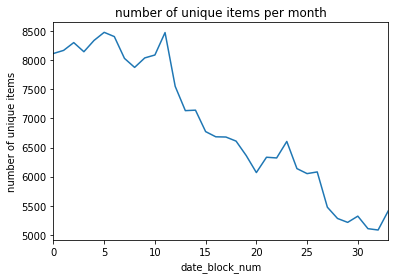

In [0]:
#group the data per month
sales_group=sales_train.groupby(['date_block_num'])['item_id']
#temp for counting number of unique items 
temp=sales_group.apply(lambda x: len(x.unique()))
print(temp.describe())
ax = temp.plot('line',title='number of unique items per month')
ax.set_ylabel('number of unique items')
plt.show()

The number of unique items is falling from around 8000 to 5000.This may explain why only small fraction of train unique items present in test.

Next check dynamics of new items.

new items appearing in each month  [1237, 798, 628, 682, 531, 447, 470, 384, 654, 489, 536, 207, 339, 310, 319, 262, 253, 316, 250, 330, 558, 460, 472, 197, 225, 336, 262, 225, 250, 206, 282, 302]


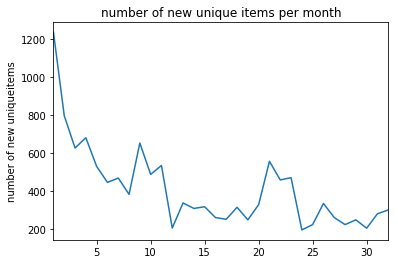

In [0]:
#make a loop to look each month how many new items are introduced
temp=[]
for i in range(1,33):
    temp.append(sum(~np.isin(sales_train[sales_train['date_block_num']==i]['item_id'].unique(),sales_train[sales_train['date_block_num']<i]['item_id'].unique())))
print("new items appearing in each month ", temp)
ax = pd.Series(temp, index=range(1,33)).plot('line',title='number of new unique items per month')
ax.set_ylabel('number of new uniqueitems')
plt.show()

All months before test indeed have new unique items; so the model will learn to detect new items.

Analysis of the distribution of items by how many months they were sold.

count    21807.000000
mean        10.726464
std          8.651442
min          1.000000
25%          3.000000
50%          9.000000
75%         16.000000
max         34.000000
Name: item_cnt_month, dtype: float64
items with 1 sale: 2999
items with 2 sales: 1445


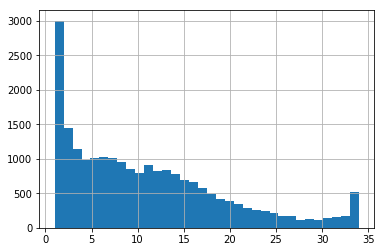

In [0]:
#group by date and items and count number of sales
temp=sales_train.groupby(["date_block_num",'item_id'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
#then again group by items and count how many months of sales existed
temp=temp.groupby('item_id')['item_cnt_month'].count()
#description of data
print(temp.describe())
#number of items with 1 and 2 sales; 
#NOTE that 302 of items appeared only in last month, and 282 in month before last
print('items with 1 sale:', sum(temp==1))
#save the items with 1 sale
items_1s=temp[temp==1].index.values
#also save the items that apperead in all months of sales
items_always=temp[temp==34].index.values
print('items with 2 sales:', sum(temp==2))
temp.hist(bins=34)

Huge amount of items with 1-2 months of sales and hump in items with all months sales.


In [0]:
#first exclude the last month and 1 month before last from deletion as they naturaly have few months of observations;
items_to_del=items_1s[~np.isin(items_1s,sales_train[sales_train["date_block_num"]==sales_train["date_block_num"].max()]["item_id"].values)]
items_to_del=items_to_del[~np.isin(items_to_del,sales_train[sales_train["date_block_num"]==(sales_train["date_block_num"].max()-1)]["item_id"].values)]
#now exclude all test 
items_to_del=items_to_del[~np.isin(items_to_del,sales_test["item_id"].values)]
print('number of items to delete: ', len(items_to_del))
#how these items to delete are distributed over periods
temp = sales_train[np.isin(sales_train['item_id'],items_to_del)]['date_block_num'].value_counts()
print('Proportion in the first 12 months',sum(temp[temp.index.isin(range(0,12))])/sum(temp))

number of items to delete:  2410
Proportion in the first 12 months 0.6413151776818333


64% of them are in the first 12 periods. They will be cut in the gridding part. 

Check how many items were new after month 12.

In [0]:
#group by items per month
temp=sales_train.groupby(["date_block_num",'item_id'])['item_cnt_day'].sum().reset_index()
#let's find the start month of sales of items
sales_train['start_month']=sales_train['item_id'].map(temp.groupby(['item_id'])["date_block_num"].min())
sales_test['start_month']=sales_test['item_id'].map(temp.groupby(['item_id'])["date_block_num"].min()).fillna(34)
#check how many items have starting period after month 12; 
temp=sales_train.groupby(['item_id','start_month']).count().reset_index()   
print('number of items with start month >=12', np.sum(temp.start_month>11)*100/temp.shape[0])

number of items with start month >=12 31.347732379511164


Around 31% of items have a starting month after month 11 - the cutting point for lags; so model will be able to learn new items distribution.

Next look at the distribution of new items per month they were introduced.

Text(0.5, 1.0, '% of items with given starting period')

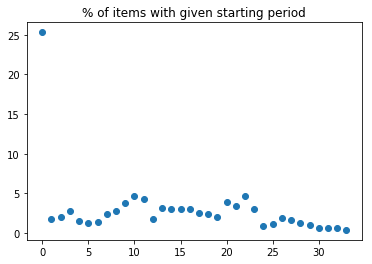

In [0]:
#look at data after month 11 which will be cut
temp=sales_train[sales_train["date_block_num"]>11].groupby(['start_month'])['item_id'].count()
plt.scatter(y=(temp*100/temp.sum()),x=temp.index)
plt.title('% of items with given starting period')

About 25% of items have starting period at month=0; overall distribution of items introduction is rather flat. 

Next check month 33 (last before test) and 34 (test).

Text(0.5, 1.0, '% of items with given starting period at month 33')

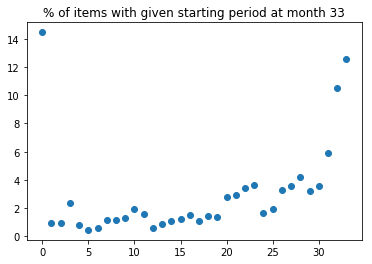

In [0]:
temp=sales_train[sales_train["date_block_num"]==33].groupby(['start_month'])['item_id'].count()
plt.scatter(y=(temp*100/temp.sum()),x=temp.index)
plt.title('% of items with given starting period at month 33')

Text(0.5, 1.0, '% of items with given starting period at test month')

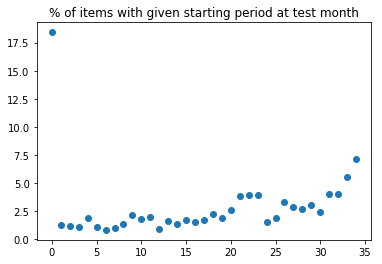

In [0]:
#finally compare it to test data
temp=sales_test.groupby(['start_month'])['item_id'].count()
plt.scatter(y=(temp*100/temp.sum()),x=temp.index)
plt.title('% of items with given starting period at test month')

There is a large population of items with start period 0 present in both month 33 and test. 

Month 33 is pretty much populated by new items what may harm validation. 

### 3. price analysis


In [0]:
temp_price=sales_train.groupby(["date_block_num",'item_id'])['item_price'].median().reset_index()
temp_price['item_price'].describe()

count    233912.000000
mean        678.304382
std        1516.947876
min           0.100000
25%         190.000000
50%         299.000000
75%         699.000000
max      307980.000000
Name: item_price, dtype: float64

Prices seems to have big outliers and data is very skewed as mean is much larger than median;

Next check the power of outliers and distribution of prices.

In [0]:
print("number of unique prices",temp_price['item_price'].unique().shape[0])
print('the 99 percentile price: ',np.percentile(temp_price['item_price'], 99))
print('max price: ',np.percentile(temp_price['item_price'], 100))
print('max price in standard deviations: ',np.percentile(temp_price['item_price'], 100)/temp_price['item_price'].std())
print('number of prices with prices above 5 sigma ',sum(temp_price['item_price'].unique()>5*temp_price['item_price'].std()))

number of unique prices 5419
the 99 percentile price:  5499.0
max price:  307980.0
max price in standard deviations:  203.02609264127307
number of prices with prices above 5 sigma  383


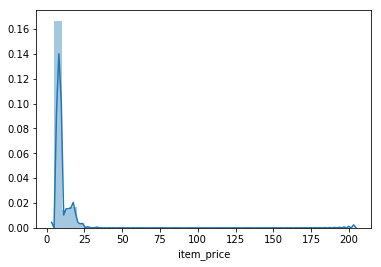

In [0]:
#the distribution of prices
temp=temp_price['item_price']/temp_price['item_price'].std()
sns.distplot(temp[temp>5], bins=40)

The distribution does not look like normal; 

To convert to normal, try to take log of price.

In [0]:
np.log(temp_price['item_price']).describe()

count    233912.000000
mean          5.880770
std           1.053106
min          -2.302585
25%           5.247024
50%           5.700444
75%           6.549651
max          12.637790
Name: item_price, dtype: float64

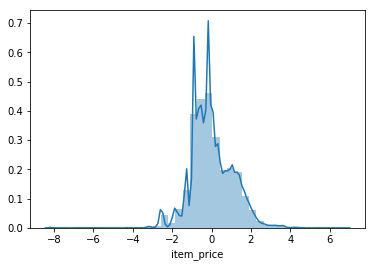

In [0]:
#distribution plotof log prices minus mean
sns.distplot((np.log(temp_price['item_price'])-np.log(temp_price['item_price']).mean()), bins=40)

Taking log of prices convert the distribution to more normal like distribution; mean is much closer to median and std is close to 1; but the outlier problem still persists: there is 1 outlier with 5 std from mean, 211 with 4 and 1708 with 3. Next clip the high end prices. 

**NOTE:** cut prices only by the distribution per given month! As prices are growing, cutting using global mean and std may cause too many prices removal. Only cut the outliers with more than 4 std from mean.

Check how things look on a fixed month.

In [0]:
month_temp=33
temp_price2=np.log(temp_price[temp_price["date_block_num"]==month_temp]['item_price'])
temp_price2.describe()

count    5413.000000
mean        6.234269
std         1.142675
min        -0.010050
25%         5.517453
50%         5.988961
75%         7.162397
max        10.645186
Name: item_price, dtype: float64

In [0]:
print('number of unique value',temp_price2.unique().shape[0])
print('the 99 percentile value: ',np.percentile(temp_price2, 99))
print('max value: ',np.percentile(temp_price2, 100))
print('max value in standard deviations: ',(np.percentile(temp_price2, 100)-temp_price2.mean())/temp_price2.std())
print('number of values with values above 3 sigma ',sum((temp_price2.unique()-temp_price2.mean())>3*temp_price2.std()))
# in this month no outliers with 4 sigma 

number of unique value 488
the 99 percentile value:  8.853522300720215
max value:  10.645186424255371
max value in standard deviations:  3.8601676936916807
number of values with values above 3 sigma  19


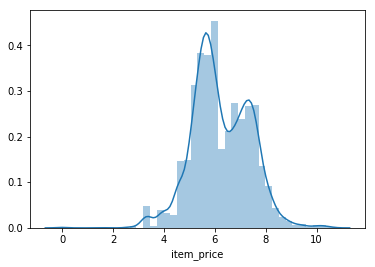

In [0]:
sns.distplot(temp_price2, bins=40)

In [0]:
#how many prices to clip
count=0
clipped_price=[]
for i in range(0,temp_price["date_block_num"].max()+1):
    temp=temp_price[temp_price["date_block_num"]==i]['item_price']
    temp2=np.exp(np.log(temp).mean()+4*np.log(temp).std())
    count+=np.sum(temp>temp2)
    if i==0:
        clipped_price=sales_train[sales_train["date_block_num"]==i]['item_price'].clip(0,temp2)
    else:
        clipped_price=pd.concat([clipped_price,sales_train[sales_train["date_block_num"]==i]['item_price'].clip(0,temp2)],axis=0)

print('times of actual outliers: ', count)

times we found actual outliers:  59


In [0]:
#make clipping
sales_train['item_price_clip']=clipped_price

The growth of prices should decrease the demand for items;

First the price level will be calculated - volume of sales divided by sales number.

Then calculate the dynamics of price level.

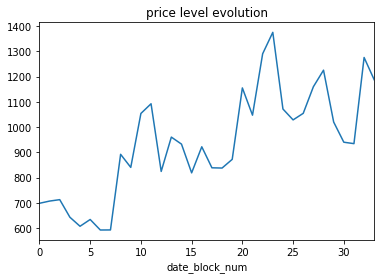

In [0]:
#classical formula of price level is: sum(price*sale)/sum(sale)
sales_train['volume']=sales_train['item_price_clip']*sales_train['item_cnt_day']
price_level=sales_train.groupby(by='date_block_num')['volume'].sum()/sales_train.groupby(by='date_block_num')['item_cnt_day'].sum()
price_level.plot('line',title='price level evolution')

Price level seems to grow and it may be interesting new feature; in order to normalize the price level, the change of price level per month will be used as feature. 

It is important for choosing how to normalize the encodings for items and shops: 

- create relative price level by normalizing price encoding by mean price of this month; such normalization will rank the items over mean price - if price of item is expensive or cheap compared to other items of that month; but lose information of dynamics of price;
- create price dynamic of encoding by taking difference; this case will show the price dynamics of given item from month to month but lose information if the item is expensive or cheap; 

Next look at the items that were sold in all periods and their price dynamics.

total change in price for most stable items %:  2.449643611907959


Text(0.5, 1.0, 'average price increase of items sold in each period (% change from month to month)')

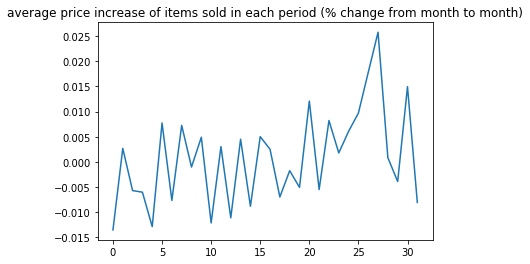

In [0]:
#first make the grouping needed for further code
temp=sales_train.groupby(['date_block_num','item_id'])['item_price_clip'].median().reset_index()
#set inflation variable
inf_2=[]
#make a loop that will count the log difference between current price level and next month price level
#log difference is the most correct way to value the difference and it is app. alike % change
for i in range(0,32):
    temp2=temp[temp['date_block_num']==i]
    temp2_2=temp[temp['date_block_num']==i+1]
    #NOTE group by does sorting of items so the difference is correct.
    inf_2.append(np.mean(np.log(temp2_2[np.isin(temp2_2['item_id'],items_always)]['item_price_clip'].values)-np.log(temp2[np.isin(temp2['item_id'],items_always)]['item_price_clip'].values)))
print("total change in price for most stable items %: ", (np.exp(np.sum(inf_2))-1)*100)
plt.plot(inf_2)
plt.title("average price increase of items sold in each period (% change from month to month)")

Most stable 500 items had a very small annual change of price. Thus, the growth of price level is mostly explained that new items have higher relative price than old items.

So relative price of item/shop is more important that its dynamic; the encodings of item and shops by price should be normalized by current month mean. 

As a result, new features can be generated:
- log change of price level before given period;
- log price level of item in previous month normalized by global price level of that month;
- log price level of shop in previous month normalized by global price level of that month;
- log price level of other categorical features in previous month normalized by global price level;


Analyze discount 

Assumption: usually prices of fixed items cannot go up inside month but they can go down because of discounts. So, take max price as price of the month.

Next check 2 features: 
- check if there were shops with discounts - that means that they have high proportion of items with prices below global median;
- items that had discount periods inside the month.


In [0]:
#first add intermonth price to the dataframe
temp=sales_train.groupby(['item_id',"date_block_num"])['item_price'].max().rename('max_price').reset_index()
#here use the unique index for shop/month to merge data
temp['temp']=temp['item_id']*100+temp["date_block_num"]
sales_train['temp']=sales_train['item_id']*100+sales_train["date_block_num"]
#use map as it is more stable than merge
sales_train['max_price']=sales_train['temp'].map(pd.Series(temp['max_price'].values,index=temp['temp'].values))
#then add low price dummy
sales_train['low_price']=(sales_train['item_price']-sales_train['max_price'])<0

count    34.000000
mean      0.169827
std       0.037071
min       0.082472
25%       0.149472
50%       0.169563
75%       0.194616
max       0.242324
Name: low_price, dtype: float64


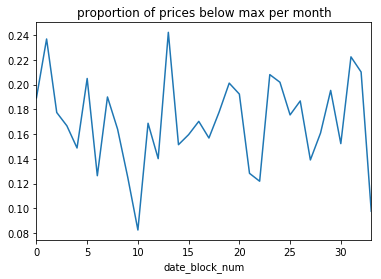

In [0]:
temp=sales_train.groupby(["date_block_num"])['low_price'].mean()
print(temp.describe())
temp.plot(title='proportion of prices below max per month')

Average 17% of items are sold below their max price per month; that is for discounts.


count    60.000000
mean      0.235184
std       0.251353
min       0.048290
25%       0.136451
50%       0.156480
75%       0.178087
max       0.983968
Name: low_price, dtype: float64
Number of discount shop:  6


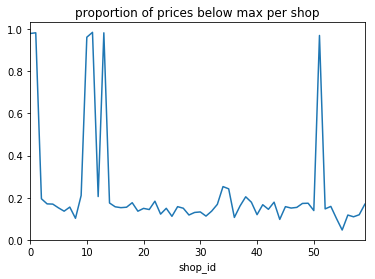

In [0]:
#group data by shops and low prices
temp=sales_train.groupby(["shop_id"])['low_price'].mean()
print(temp.describe())
temp.plot(title='proportion of prices below max per shop')
print('Number of discount shop: ', sum(temp>0.9))

About 16% of items per shop are sold below max price but suddenly there are 6 shops that sold 98% of items below max - must be a discount shop .

Then check the volume of sales with discount compared to proportion of such sales; Idea is to check if discounts stimulate the sales;

count    34.000000
mean      0.196594
std       0.042024
min       0.112169
25%       0.168921
50%       0.194781
75%       0.217540
max       0.325961
dtype: float64


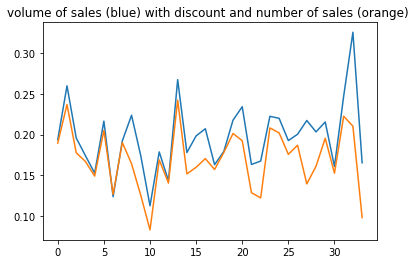

In [0]:
#check the volume of sales 
sales_train['low_sale']=sales_train['low_price']*sales_train['item_cnt_day']
#now per item volume of discounted sales
temp=sales_train.groupby(["date_block_num"])['low_sale'].sum()/sales_train.groupby(["date_block_num"])['item_cnt_day'].sum()
print(temp.describe())
plt.plot(temp)
plt.plot(sales_train.groupby(["date_block_num"])['low_price'].mean())
plt.title('volume of sales (blue) with discount and number of sales (orange) ')
plt.show()

The sales with discounted price is higher than the count of such sales meaning that discounts works and boost sales.

New feature for both item and shops will be generated - proportion of sales with discount.


### 4. sales analysis
    

In [0]:
#group the data per month
sales_month=sales_train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
print("any no sales: ",sum(sales_month==0))
sales_month.describe()

any no sales:  2583


count    1.609124e+06
mean     2.267200e+00
std      8.614824e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

In [0]:
#the predicted data is clippedn
sales_month.clip(0,20).describe()
#std decreased dramatically

count    1.609124e+06
mean     2.022806e+00
std      2.574126e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_day, dtype: float64

In [0]:
#try log
np.log(sales_month.clip(0,20)+1).describe()

count    1.609124e+06
mean     9.639624e-01
std      4.630907e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      1.098612e+00
max      3.044523e+00
Name: item_cnt_day, dtype: float64

In [0]:
#try sqrt
np.sqrt(sales_month.clip(0,20)+3/8).describe()

count    1.609124e+06
mean     1.447131e+00
std      5.510158e-01
min      6.123724e-01
25%      1.172604e+00
50%      1.172604e+00
75%      1.541104e+00
max      4.513868e+00
Name: item_cnt_day, dtype: float64

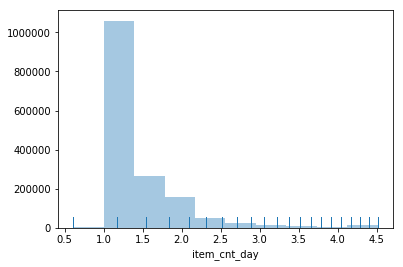

In [0]:
sns.distplot(np.sqrt(sales_month.clip(0,20)+3/8), bins=10, kde=False, rug=True)

In [0]:
#now sales of shops distribution
sales_month.groupby('shop_id').sum().describe()

count        60.000000
mean      60803.433594
std       57992.902344
min         330.000000
25%       23333.000000
50%       50176.000000
75%       69562.250000
max      310777.000000
Name: item_cnt_day, dtype: float64

In [0]:
#now sales of shops distribution after log
np.log(sales_month.groupby('shop_id').sum()).describe()

count    60.000000
mean     10.485998
std       1.295843
min       5.799093
25%      10.053417
50%      10.823255
75%      11.149886
max      12.646831
Name: item_cnt_day, dtype: float64

In [0]:
#now sales per months distribution after log
np.log(sales_month.groupby('date_block_num').sum()).describe()

count    34.000000
mean     11.549065
std       0.268030
min      11.053854
25%      11.361116
50%      11.583439
75%      11.738933
max      12.119108
Name: item_cnt_day, dtype: float64

Sales data is very skewed as mean is 2 while median is 1; std is huge;

Clipping the data only decrease std to more or less normal values but do not cure the mean - median problem;

Logging helps to decrease the problem of median-mean but not fully; 

Take sqrt of the data and it seems to work much better - std falls even more and mean is closet to median.

For shops and months the log of sales seems a good transformation for normalization.


Next analyze the dynamics of sales.

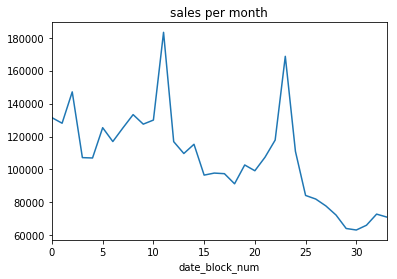

In [0]:
sales_month.reset_index().groupby('date_block_num')['item_cnt_day'].sum().plot('line', title='sales per month')

Sales are dropping all the time except for 2 special cases - those are December sales. In that month sales go up.

Several ways to explain negative dynamics of sales: 
- number of item ids decreased, 
- general drop in sales.  

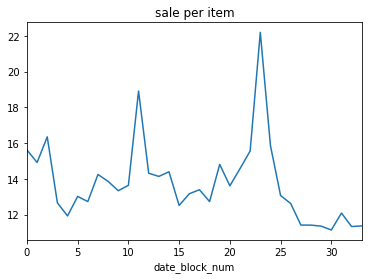

In [0]:
#first check sale per item in order to check idea of decrease because of fall of number of items
sales_item=sales_month.clip(0,20).reset_index().groupby('date_block_num')['item_cnt_day'].sum()/sales_group.apply(lambda x: len(x.unique()))
sales_item.plot('line',title='sale per item')
#and it seems to be correct idea

As a result, Sales per item are much more stable than sales; It means that general decrease of sales is more explained by fall of number of items presented before.


### 5. structure analysis for test data and train data  



Check the distribution of items per shop in test and train

In [0]:
#check how many shops each item cover
sales_test.groupby('item_id')['shop_id'].count().value_counts()

42    5100
Name: shop_id, dtype: int64

In [0]:
sales_train.groupby('item_id')['shop_id'].count().value_counts().head()

1    2371
2    1054
3     669
4     540
5     470
Name: shop_id, dtype: int64

In test all shops have all items (each item is presented in 42 shops); 

In train some shops have some items but not all; 

It is obvious that test data consists of all combinations of items and shops. So train data must be modified for the model in order to correctly make predictions for the test data;

Next stage of test data analysis is to try to understand if data is in random order or sorted. 

In [0]:
print('unique shops',sales_test['shop_id'].unique())
#here I check if sorted by shops
print('check if sorted by shops',len(sales_test['shop_id'].unique()),np.sum(sales_test['shop_id'].diff()!=0))
#here I check if sorted by items
print('check if sorted by shops',len(sales_test['item_id'].unique()),np.sum(sales_test['item_id'].diff()!=0))

unique shops [ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]
check if sorted by shops 42 42
check if sorted by shops 5100 214200


Sales are grouped by shops and not by items; The reason is that shops changed 42 times while there is 42 shops while for items the change of items happened more times than number of items. However, shops are not sorted - shops ids do not show linear pattern.

Next check if shops are given items in unique order or in the same order.

In [0]:
temp=sales_test[sales_test['shop_id']==5]['item_id'].unique()
z=0
for i in list(sales_test['shop_id'].unique()):
    z+=np.sum(sales_test[sales_test['shop_id']==i].item_id.unique()-temp)
print('if items are given in the same order for each shop', z==0)
#as it may be seen the items are given to each shop in the same order; 

if items are given in the same order for each shop True


Data in test file was grouped by shop and order of items is the same for each shop.

There is no linear pattern in shop id but they also do not look random; next check how shops appear in train. If some shops appear near other shops more often. 

In [0]:
stack=[]
temp_3=1
shop=[]
month=[]
#this function look per day how the shops are distributed - 
#how many times a shop appeared in a row and what shop was near it; 
for i in range(sales_train.shape[0]-1):
    if i==0:
        shop+=[sales_train['shop_id'][i]]
        month+=[sales_train['date_block_num'][i]]
    if sales_train['shop_id'][i+1]==sales_train['shop_id'][i]:
        temp_3+=1
    else:
        stack+=[temp_3]
        shop+=[sales_train['shop_id'][i+1]]
        month+=[sales_train['date_block_num'][i+1]]
        temp_3=1
        
#shops distribution
shops_distribution={}
temp_3=[]
#in this function 
for j in np.unique(shop):
    for z in list(np.where(np.isin(shop,j))[0]):
        if z+1<len(shop):
            temp_3+=[shop[z+1]]
    shops_distribution[j]=temp_3
    temp_3=[]

In [0]:
#finally have a look at one shop and how is the distribution
a,b = np.unique(shops_distribution[50],return_counts=True)
pd.DataFrame(zip(a,b))

,0,1
0,3,1
1,5,7
2,6,2
3,7,2
4,15,2
5,25,1
6,31,1
7,38,1
8,42,8
9,43,10


Shops are linear sorted generally; for example, shop 50 is mostly surrounded by shops 49 and 51 and sometimes by other; The same happens to other shops. As a result, a potential leakage can exist: first unique items of first shop are taken, then unique items of second and so on; as a result, first few items must have higher sales probability in first shop due to this algorithm.  

<function matplotlib.pyplot.show>

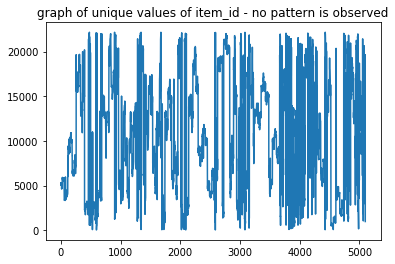

In [0]:
plt.plot(sales_test[sales_test['shop_id']==5]['item_id'].unique())
plt.title('graph of unique values of item_id - no pattern is observed')
plt.show


### 6. grid and lag



Make grid of data: make the combination of each shop and item (if there was sale add this sale, if not - set sale to zero).

In [0]:
#function 1 group the data and clip the prices and sales
def group_data(data_file, clip=True,save_str=True):
    '''
    in this file group data per month;
    data_file is initial file;
    clip is variable if to clip prices and sales or not;
    save_str is whether to save order of shops and items per month; 
    groupby would sort shops and original order of shops might need to be saved for future index feature.
    '''
    if save_str==True:
        cur_shops=[]
        cur_items=[]
        for block_num in range(0,data_file["date_block_num"].max()+1):
            cur_shops += [data_file[data_file['date_block_num']==block_num]['shop_id'].unique()]
            cur_items += [data_file[data_file['date_block_num']==block_num]['item_id'].unique()]
    #Here start grouping data per month; 
    #first the columns to merge on;
    index_cols = ['date_block_num','shop_id','item_id']
    #make grouping;
    temp=data_file.groupby(index_cols,as_index=False)
    #merge the sales and rename them to target;
    data_group=temp['item_cnt_day'].sum()
    data_group.rename(columns = {'item_cnt_day':'target'}, inplace = True)
    #add the max of prices;
    data_group["item_price"]=temp["item_price"].max()["item_price"]
    #next stage is clipping;
    if clip==True:
        #clipping target for outliers; in a way they are making my code worse;
        data_group['target']=data_group['target'].clip(0,20)
        #for stability of future code I will clean the data from zero entries - not much but still;
        data_group=data_group[data_group['target']!=0]
        #prices are more complicated; 
        clipped_price=[]
        for i in range(0,data_group["date_block_num"].max()+1):
            temp=data_group[data_group["date_block_num"]==i]['item_price']
            temp2=np.exp(np.log(temp).mean()+4*np.log(temp).std())
            if i==0:
                clipped_price=data_group[data_group["date_block_num"]==i]['item_price'].clip(0,temp2)
            else:
                clipped_price=pd.concat([clipped_price,data_group[data_group["date_block_num"]==i]['item_price'].clip(0,temp2)],axis=0)
        data_group["item_price"]=clipped_price
        
    if save_str==True:
        return [data_group,[cur_shops,cur_items]]
    else:
        return data_group

def grid_gen(df,temp_order=None,save_str=True):
    '''
    input is the grouped data and saved order of unique shops and items; 
    '''
    #first the columns to merge on
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    #then make a grid as combination of all active shops and active items of given month;
    grid = [] 
    for block_num in range(0,df["date_block_num"].max()+1):
        #in case care about correct order
        if save_str==True:
            cur_shops = temp_order[0][block_num]
            cur_items = temp_order[1][block_num]
        # in case do not care
        else:
            cur_shops = df[df['date_block_num']==block_num]['shop_id'].unique()
            cur_items = df[df['date_block_num']==block_num]['item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    #convert grid to DataFrame
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
    #finally make the mapping trick to pass the sales values to grid
    grid['temp']=grid['item_id']*10000+grid['shop_id']*100+grid['date_block_num']
    df['temp']=df['item_id']*10000+df['shop_id']*100+df['date_block_num']
    grid['target']=grid["temp"].map(pd.Series(df["target"].values,index=df["temp"].values)).fillna(0)
    #drop temp
    grid=grid.drop(columns=["temp"])
    return grid

In [0]:
#make a grid
df, temp_unique=group_data(sales_train)
df=grid_gen(df,temp_unique)

Then make 2 features:
- last month sale;
- if item is new;

In [0]:
#here make shift 
train_shift = df[['date_block_num','shop_id','item_id','target']].copy()
#make a shift of data by month_shift
train_shift['date_block_num'] = train_shift['date_block_num'] + 1
#make naming
foo = lambda x: '{}_lag_{}'.format(x, 1) if x in ['target'] else x
train_shift = train_shift.rename(columns=foo)  
#instead of merge use map for target - much faster
train_shift['temp']=train_shift['date_block_num']*10000000+train_shift['shop_id']*100000+train_shift['item_id']
df['temp']=df['date_block_num']*10000000+df['shop_id']*100000+df['item_id']
#do mapping
df['{}_lag_{}'.format('target', 1)]=df['temp'].map(pd.Series(train_shift['{}_lag_{}'.format('target', 1)].values,index=train_shift['temp'].values)).fillna(0)
#cut the data by 12 month
df=df[df['date_block_num']>=12]
#now add start month
df['start_month']=df['item_id'].map(df.groupby(['item_id'])["date_block_num"].min())

(array([5.505754e+06, 6.038720e+05, 1.545520e+05, 6.033400e+04,
        3.086500e+04, 1.835600e+04, 1.169400e+04, 7.896000e+03,
        5.872000e+03, 4.230000e+03, 3.335000e+03, 2.414000e+03,
        2.001000e+03, 1.642000e+03, 1.335000e+03, 1.103000e+03,
        9.430000e+02, 8.210000e+02, 7.170000e+02, 7.358000e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.], dtype=float32),
 <a list of 20 Patch objects>)

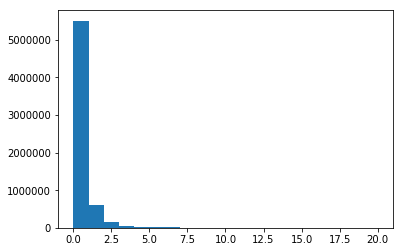

In [0]:
#but big skew to 0
plt.hist(df['target'],bins=20)

In [0]:
(df['target'].value_counts()/df.shape[0]).head()

0.0    0.856914
1.0    0.093986
2.0    0.024054
3.0    0.009390
4.0    0.004804
Name: target, dtype: float64

After converting data to grid, 85% of 0 values. This is a big problem for any model as the data is not balanced; Then the model will learn to predict 0. 

There are several solutions to this problem:
- over sample data - artificially increase number of low occurring observations; this will improve data size hugely which will crash the machine in the future's calculation;
- under sample data - artificially decrease number of high occurring observations; this will harm gridding;
- split the data and fit one more model on balanced part of data while fit another model on less balanced part; It is much better solution, but split must be found manually.


Check mean and MSE

In [0]:
print('mean of sales of data without last month sale',df[df['target_lag_1']==0]['target'].mean())
print('mean of sales of data with last month sale',df[df['target_lag_1']>0]['target'].mean())
print('MSE of data without last month sale',((df[df['target_lag_1']==0]['target']-df[df['target_lag_1']==0]['target'].mean())**2).mean())
print('MSE of data with last month sale',((df[df['target_lag_1']>0]['target']-df[df['target_lag_1']>0]['target'].mean())**2).mean())

mean of sales of data without last month sale 0.14393791556358337
mean of sales of data with last month sale 1.1690014600753784
MSE of data without last month sale 0.5515287226911555
MSE of data with last month sale 5.750149266437342


The data distribution for data with last month sale and no sale is very different and there is big potential to decrease the MSE by working with data with last month sale.

Next check probability of zero sales given last month sale.


In [0]:
print('probability of zero sales given before was zero sales before',np.sum(np.logical_and(df['target_lag_1']==0,df['target']==0))/np.sum(df['target_lag_1']==0))
print('probability of one sale given before was zero sales before',np.sum(np.logical_and(df['target_lag_1']==0,df['target']==1))/np.sum(df['target_lag_1']==0))
print('probability of two sales given before was zero sales before',np.sum(np.logical_and(df['target_lag_1']==0,df['target']==2))/np.sum(df['target_lag_1']==0))
print('probability of zero sales given before was one sale before',np.sum(np.logical_and(df['target_lag_1']==1,df['target']==0))/np.sum(df['target_lag_1']==1))
print('probability of one sale given before was one sale before',np.sum(np.logical_and(df['target_lag_1']==1,df['target']==1))/np.sum(df['target_lag_1']==1))
print('probability of two sales given before was one sale before',np.sum(np.logical_and(df['target_lag_1']==1,df['target']==2))/np.sum(df['target_lag_1']==1))

probability of zero sales given before was zero sales before 0.9079968688289899
probability of one sale given before was zero sales before 0.07153538172551854
probability of two sales given before was zero sales before 0.012307804827535768
probability of zero sales given before was one sale before 0.6679433998971666
probability of one sale given before was one sale before 0.22693368630230262
probability of two sales given before was one sale before 0.06676012006503523


Text(0.5, 1.0, 'the probability of zero sales depending on the value of sales before')

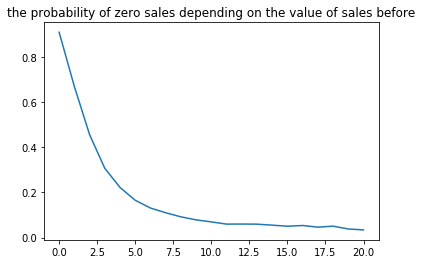

In [0]:
temp=[]
for i in range(21):
    temp.append(np.sum(np.logical_and(df['target_lag_1']==i,df['target']==0))/np.sum(df['target_lag_1']==i))
plt.plot(temp)
plt.title('the probability of zero sales depending on the value of sales before')

Text(0.5, 1.0, 'the probability of sales value depending on the value of sales before')

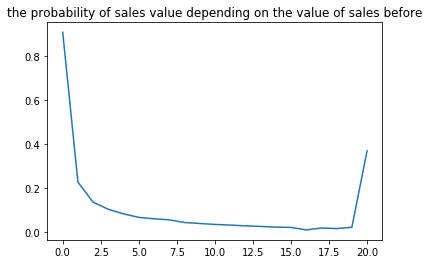

In [0]:
temp=[]
for i in range(21):
    temp.append(np.sum(np.logical_and(df['target_lag_1']==i,df['target']==i))/np.sum(df['target_lag_1']==i))
plt.plot(temp)
plt.title('the probability of sales value depending on the value of sales before')

Last month sale is powerful predictor and must be used to split the data;

Now check the distribution;

In [0]:
#distribution for dataset with last value more then 0
temp=df[df['target_lag_1']>0]
print('distribution of target for data with lag_1>0',(temp['target'].value_counts()/temp.shape[0]).head())
print('distribution of lag_1 for data with lag_1>0',(temp['target_lag_1'].value_counts()/temp.shape[0]).head())
#interesting that the most common change is fall of sales from 1 to zero which happens in 54% of time

distribution of target for data with lag_1>0 0.0    0.543836
1.0    0.231586
2.0    0.096048
3.0    0.045708
4.0    0.025347
Name: target, dtype: float64
distribution of lag_1 for data with lag_1>0 1.0    0.638743
2.0    0.174342
3.0    0.069264
4.0    0.035734
5.0    0.021261
Name: target_lag_1, dtype: float64


In [0]:
#distribution for dataset with last value == 0
temp=df[df['target_lag_1']==0]
print('distribution of target for data with lag_1==0', (temp['target'].value_counts()/temp.shape[0]).head())

distribution of target for data with lag_1==0 0.0    0.907997
1.0    0.071535
2.0    0.012308
3.0    0.003465
4.0    0.001452
Name: target, dtype: float64


So data with lag_1>0 has also 0 as most common value but it is not as bad as for items without sale - they have 90% of zeros; 

It would be very hard for any model to fit correctly with such unbalanced data; So it's good to split the lag_1==0 data;

The other idea is further split the data with items that first were observed at the current months.


In [0]:
df['if_new']=df['start_month']==df['date_block_num']
temp=df[df['target_lag_1']==0]

In [0]:
print('mean value of items without last month sale', temp['target'].mean())
print('MSE of items without last month sale', np.mean((temp['target']-temp['target'].mean())**2))

mean value of items without last month sale 0.14393791556358337
MSE of items without last month sale 0.5515287226911555


In [0]:
#check the distribution of target for items that were sold for many periods
temp2=temp[temp['if_new']==False]
print('mean value of old items', temp2['target'].mean())
print('MSE of old items', np.mean((temp2['target']-temp2['target'].mean())**2))
(temp2['target'].value_counts()/temp2.shape[0]).head()

mean value of old items 0.11547110229730606
MSE of old items 0.23439758587845333


0.0    0.912146
1.0    0.071632
2.0    0.011375
3.0    0.002734
4.0    0.000954
Name: target, dtype: float64

In [0]:
#check the distribution of target for items that were sold for 1 period
temp2=temp[temp['if_new']==True]
print('mean value of new items', temp2['target'].mean())
print('MSE of new items', np.mean((temp2['target']-temp2['target'].mean())**2))
(temp2['target'].value_counts()/temp2.shape[0]).head()

mean value of new items 0.3287334144115448
MSE of new items 2.570810774594461


0.0    0.881063
1.0    0.070911
2.0    0.018365
3.0    0.008207
4.0    0.004684
Name: target, dtype: float64

Overall if_new is a good feature and it can be a good way to split the data - new items have higher mean than old but they also have large potential for MSE reduction as new items MSE is 2.57 while old items have only 0.23.

Summary: split the data by lag_1 and if_new

### 7. the order analysis for shop and item


Hypothesis: first items for the first shop have higher probability of sales due to stacking of items; 

First check how many items per shop in date 33.

mean items per shop 716.6136363636364


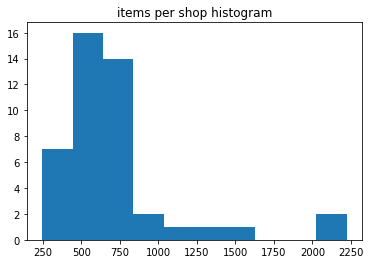

In [0]:
temp=sales_train[sales_train['date_block_num']==33]
temp_2=[]
for i in temp['shop_id'].unique():
    temp_2+=[len(temp[temp['shop_id']==i]['item_id'].unique())]
plt.hist(temp_2)
plt.title('items per shop histogram')
print('mean items per shop', np.mean(temp_2))

Around 700 items per shop on average; 

So first 700 items for first shop might have higher probability of sale and so on, and check this using target_lag_1.

If so, there would be higher values of lag_1 for first items and lower for last items; If items are added randomly then there wil be no pattern.

In [0]:
train_shift = df[df['date_block_num']==33][['shop_id','item_id','target']].copy()
#make naming
foo = lambda x: '{}_lag_{}'.format(x, 1) if x in ['target'] else x
train_shift = train_shift.rename(columns=foo)  
    #instead of merge use map for target - much faster
train_shift['temp']=train_shift['shop_id']*100000+train_shift['item_id']
sales_test['temp']=sales_test['shop_id']*100000+sales_test['item_id']
    #do mapping
sales_test['{}_lag_{}'.format('target', 1)]=sales_test['temp'].map(pd.Series(train_shift['{}_lag_{}'.format('target', 1)].values,index=train_shift['temp'].values)).fillna(0)

In [0]:
sales_test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45])

<function matplotlib.pyplot.show>

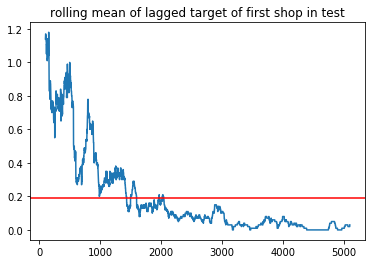

In [0]:
#finally the distribution of target_lag_1 rolling mean 
temp=sales_test[sales_test['shop_id']==5]['target_lag_1'].rolling(100).mean().values
plt.plot(temp)
plt.axhline(np.nanmean(temp), color='r')
plt.title('rolling mean of lagged target of first shop in test')
plt.show

For the first shop (5) it is clearly seen that first 1000 items have much higher lagged target than the rest; 

What about the last shop?

<function matplotlib.pyplot.show>

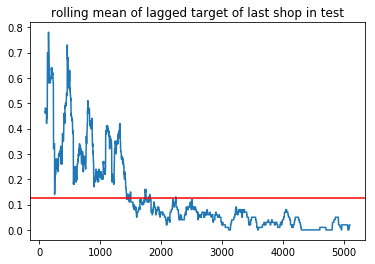

In [0]:
#finally the distribution of target_lag_1 rolling mean 
temp=sales_test[sales_test['shop_id']==45]['target_lag_1'].rolling(100).mean().values
plt.plot(temp)
plt.axhline(np.nanmean(temp), color='r')
plt.title('rolling mean of lagged target of last shop in test')
plt.show

It seems that some items are very common for all shops; but the first 1000 items of shop 45 are lower that those of shop 5 and still the distribution is more random and there are more humps for the last shop.

Check if train data will reflect this pattern for month 33.

In [0]:
df[df['date_block_num']==33]['shop_id'].unique()

array([45, 46, 44, 41, 39, 42, 34, 31, 35, 38, 37, 36,  6, 56, 57, 55, 58,
       59, 48, 47, 49, 53, 52, 50, 16, 15, 12, 14, 20, 19, 22, 18,  5,  4,
        2,  3,  9,  7, 10, 28, 26, 25, 24, 21])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show>

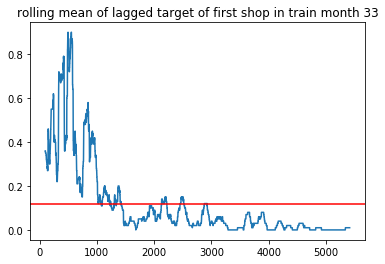

In [0]:
#finally the distribution of target_lag_1 rolling mean 
temp=df[df['date_block_num']==33][df['shop_id']==45]['target_lag_1'].rolling(100).mean().values
plt.plot(temp)
plt.axhline(np.nanmean(temp), color='r')
plt.title('rolling mean of lagged target of first shop in train month 33')
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show>

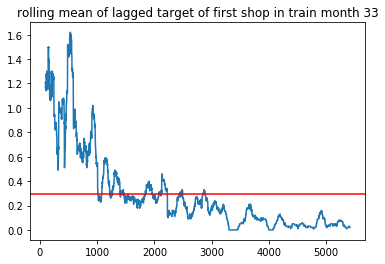

In [0]:
#finally the distribution of target_lag_1 rolling mean 
temp=df[df['date_block_num']==33][df['shop_id']==21]['target_lag_1'].rolling(100).mean().values
plt.plot(temp)
plt.axhline(np.nanmean(temp), color='r')
plt.title('rolling mean of lagged target of last shop in train month 33')
plt.show

Overall the pattern may be observed - first items seem to have much higher rolling mean than last; 

So several features might be generated:  the order of unique items per shop, rolling means of lagged targets of items.

## shops file analysis

In [0]:
#read file
shops = pd.read_csv(os.path.join(data_place, 'shops-translated.csv'))

In [0]:
shops.columns = ['shop_name', 'shop_id']
#info of shops
print("shape is ", shops.shape)
print(shops.info())
shops.head()

shape is  (60, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
None


,shop_name,shop_id
0,"Yakutsk Ordzhonikidze, 56 francs",0
1,"Yakutsk TC ""Central"" franc",1
2,"Adygea Shopping Center ""Mega""",2
3,"Balashikha TRK ""October-Kinomir""",3
4,"Volzhsky shopping center ""Volga Mall""",4


In [0]:
#check how many shops in test
shops_test=sales_test['shop_id'].unique()
print('number of shops in test:', len(shops_test))
#small subtest - do test have new shops?
print('number of new shops in test:',sum(~np.isin(shops_test,shops['shop_id'])))

number of shops in test: 42
number of new shops in test: 0


There is only 42 shops out of 60 in test - potentially some shops can be cut to clean the data; There are no new shops in test; 

Shop name seems to have structure as name of city and then name of the shop, which can generate a nice city feature.

In [0]:
#city variable creation
shops['city']=shops.iloc[:,0].apply(lambda x: x.split(" ")).apply(lambda x: x[0])
#let's see the cities
shops['city'].unique()

array(['Yakutsk', 'Adygea', 'Balashikha', 'Volzhsky', 'Vologda',
       'Voronezh', 'Outbound', 'Zhukovsky', 'Online', 'Kazan', 'Kaluga',
       'Colosseum', 'Krasnoyarsk', 'Kursk', 'Moscow', 'Mytischi',
       'N.Novgorod', 'Nizhny', 'Novosibirsk', 'Omsk', 'RostovNaDon',
       'RostovNaDonu', 'SPb', 'Samara', 'Sergiev', 'Surgut', 'Tomsk',
       'Tyumen', 'Ufa', 'Khimki', 'Digital', 'Chekhov', 'Yaroslavl'],
      dtype=object)

In [0]:
shops.iloc[[0,1,57,58]]
#shops 0 and 1 are equal to 57 and 58 respectively

,shop_name,shop_id,city
0,"Yakutsk Ordzhonikidze, 56 francs",0,Yakutsk
1,"Yakutsk TC ""Central"" franc",1,Yakutsk
57,"Yakutsk Ordzhonikidze, 56",57,Yakutsk
58,Yakutsk Central shopping center,58,Yakutsk


In [0]:
np.sort(sales_test.shop_id.unique())

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

These mistakes don't appear in test; 

Hypothesis: if shop is not in test then it may have some mistake in it

In [0]:
#check who is not in test
shops['shop_name'][~np.isin(shops['shop_id'],shops_test)]

0                 Yakutsk Ordzhonikidze, 56 francs
1                       Yakutsk TC "Central" franc
8                    Voronezh TRC City-Park "Grad"
9                                   Outbound Trade
11                    Zhukovsky Str. Chkalov 39 m²
13                              Kazan TC "Behetle"
17     Krasnoyarsk Shopping center "Vzletka Plaza"
20                                   Moscow "Sale"
23                Moscow TC "Budenovskiy" (pav.A2)
27                Moscow ТЦ "MEGA Belaya Dacha II"
29            Moscow TC "New Century" (Novokosino)
30                       Moscow TP TPP "Perlovski"
32           Moscow Shopping Center "Silver House"
33                             Mytischi TRK "XL-3"
40    RostovNaDonu TRC "Megacenter Horizon" Island
43                                SPb TK "Sennaya"
51            Tyumen Shopping Center "Green Beach"
54                                Khimki ТЦ "Mega"
Name: shop_name, dtype: object

Manually checked the shops for mistakes and found that:
shops [0,1,11] are effectively equal to shops [57,58,10]

In [0]:
#clean out the mistakes
shops_to_change=[[0,1,11],[57,58,10]]
#below is example of how to make the changes 
for i in range(len(shops_to_change[0])):
    sales_train.loc[sales_train["shop_id"]==shops_to_change[0][i],'shop_id']=shops_to_change[1][i]

check shops not in test

In [0]:
#for next decision making it would be useful to outline some stat on shops sales
sales_train.groupby(by=['shop_id'])['item_cnt_day'].sum().describe()
#Now return to shops not in test
shops_not_test=sales_train['shop_id'].unique()[~np.isin(sales_train['shop_id'].unique(),shops_test)]
#now select only part of sales with such shops and group by the shops
temp=sales_train[np.isin(sales_train['shop_id'],shops_not_test)].groupby(by=['shop_id'])
#first how many sales not in test shops made;
print('sales of not in test shops',temp['item_cnt_day'].sum())
#then in how many unique periods they appeared;
print('how many periods they appear ',temp['date_block_num'].apply(lambda x: len(x.unique())))
#then when they appeared;
print('when they started to sell ',temp['date_block_num'].apply(lambda x: x.min()))
#then when they last appeared;
print('when they stop selling ',temp['date_block_num'].apply(lambda x: x.max()))

sales of not in test shops shop_id
8       3595.0
9      15866.0
13     19763.0
17     25838.0
20      5872.0
23      7705.0
27    136657.0
29     58713.0
30     60828.0
32      8781.0
33      5482.0
40      4943.0
43     50608.0
51     48767.0
54    185790.0
Name: item_cnt_day, dtype: float32
how many periods they appear  shop_id
8      4
9      4
13    20
17    20
20     2
23     4
27    32
29    29
30    26
32     7
33     9
40    11
43    25
51    33
54    28
Name: date_block_num, dtype: int64
when they started to sell  shop_id
8      0
9      9
13     0
17     5
20    21
23     0
27     0
29     0
30     0
32     0
33    19
40    14
43     0
51     0
54     0
Name: date_block_num, dtype: int64
when they stop selling  shop_id
8      3
9     33
13    19
17    24
20    33
23     3
27    32
29    28
30    25
32     6
33    27
40    24
43    24
51    32
54    27
Name: date_block_num, dtype: int64


In [0]:
print(temp['date_block_num'].apply(lambda x: x.unique()))

shop_id
8                                          [0, 1, 2, 3]
9                                       [9, 21, 27, 33]
13    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
17    [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
20                                             [21, 33]
23                                         [0, 1, 2, 3]
27    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
29    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
30    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
32                                [0, 1, 2, 3, 4, 5, 6]
33                 [19, 20, 21, 22, 23, 24, 25, 26, 27]
40         [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
43    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
51    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
54    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Name: date_block_num, dtype: object


As it may be seen shops [8,9,20,29,30,32,33,54] are to be deleted as they have quite low sales compared to general statistics or useful information for test.


In [0]:
#shops to delete
shops_to_delete=[8,9,20,29,30,32,33,54]
#below is function to delete
sales_train=sales_train[np.logical_not(sales_train["shop_id"].isin(shops_to_delete))]

Finally I want to check when shops appeared;

In [0]:
#find dates of shops opening
temp=sales_train.groupby('shop_id')["date_block_num"].min()

In [0]:
#shops that opened after 12 month
temp[temp>=12]

shop_id
34    18
36    33
39    14
40    14
48    15
Name: date_block_num, dtype: int32

In [0]:
sales_train[sales_train['shop_id']==36].item_cnt_day.sum()

330.0

It seems that most shops opened far in history except for 1 shop - it opened just on 33rd period. But it is a small shop with only 330 monthly sales - should not be a problem;
Summary:
- additional feature city may be extracted for the model;
- shops with mistakes will be merged;
- shops to delete were found as they give low information and do not present in test.

## items file analysis

In [0]:
#read the file
items = pd.read_csv(os.path.join(data_place, 'items-translated.csv'))

In [0]:
#info of file
print("shape is ", items.shape)
print(items.info())
items.head()

shape is  (22170, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None


,item_name,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


New information is the item name; So the analysis will focus on the text features that can be extracted; 

Next check the most common words in names of items.

In [0]:
#first clean the text by deleting useless character, deleting useless spaces, lowering data
items_clean=items['item_name'].str.replace(r'[^\w\s]', ' ').str.replace(r' +', ' ').apply(lambda x: x.lower().strip())

In [0]:
#check if there are words that can be found in 1% of test items
vect = TfidfVectorizer(min_df=0.01,  ngram_range=(1,2),stop_words='english').fit(items_clean)
print('the size of ngram vocabulary',len(vect.vocabulary_.keys()))

the size of ngram vocabulary 69


In [0]:
vect.vocabulary_.keys()

dict_keys(['edition', 'pc', 'digital', 'version', 'edition pc', 'pc digital', 'digital version', 'box', 'new', 'love', 'region', 'collection', 'ps3', 'russian', 'ps3 russian', 'russian version', 'jewel', 'pc jewel', 'jewel russian', 'xbox', '360', 'xbox 360', '360 russian', 'bd', 'best', 'mp3', 'cd', 'digipack', 'mp3 cd', 'cd digipack', 'cd jewel', 'english', '2cd', 'dvd', '1c', 'war', 'series', 'audiobooks', '1c audiobooks', 'world', 'year', 'black', 'ps', 'art', 'time', 'toy', 'set', 'game', 'season', 'english version', 'lp', 'фирм', '3d', '3d bd', 'subtitles', 'russian subtitles', 'documentation', 'russian documentation', 'pc russian', 'assassin', 'creed', 'assassin creed', 'board', 'soft', 'sat', 'shirt', 'soft toy', 'board game', 'фигурка'])

Lot's of most common words are not so usefull: they will be reflected in future in categories like pc version, PS, digital;

So check how many words are in 0.1% of items.

In [0]:
vect = TfidfVectorizer(min_df=0.001,  ngram_range=(1,2),stop_words='english').fit(items_clean)
print('the size of ngram vocabulary',len(vect.vocabulary_.keys()))

the size of ngram vocabulary 1044


There is 104 words in names that are quite common for train; 

The words that present in test items names are most important.

In [0]:
items_clean_test=items_clean[sales_test['item_id'].unique()]
len(items_clean_test)
#first check if there is any leakage by name - names that happen too often - check all words that occure at least in 1% of names
vect_test = TfidfVectorizer(min_df=0.01,  ngram_range=(1,2),stop_words='english').fit(items_clean_test)
print('the size of ngram vocabulary in test',len(vect_test.vocabulary_.keys()))

the size of ngram vocabulary in test 79


In [0]:
vect_test.vocabulary_.keys()

dict_keys(['ps3', 'russian', 'subtitles', 'ps3 russian', 'russian subtitles', 'версия', 'classics', 'xbox', '360', 'xbox 360', 'ps4', 'version', 'ps4 russian', 'russian version', '360 russian', 'documentation', 'russian documentation', 'pc', 'pc russian', 'edition', 'minecraft', 'english', 'english version', 'best', 'jewel', 'pc jewel', 'jewel russian', 'game', 'black', 'collection', 'set', 'war', 'dvd', 'xbox russian', 'world', 'year', 'time', '3d', 'series', 'wot', 'rem', 'firms', 'wb', 'bd', 'assassin', 'creed', 'assassin creed', 'region', 'art', 'soft', 'box', 'edition pc', '3d bd', 'digital', 'pc digital', 'digital version', 'new', '2cd', 'digipack', 'cd', '1c', 'board', 'board game', 'toy', 'soft toy', 'sat', 'songs', 'comic', 'volume', 'adventure', 'adventure time', 'disney', 'фигурка', '2lp', 'lp', 'mp3', 'mp3 cd', 'cd jewel', 'cd digipack'])

Words that appear in more than 1% of test items are more or less the same as in train and are more categorical names; 

As a result, try to extract all words that appear in more than 0.5% (0.1% is too large) of test items names.

In [0]:
vect_test = TfidfVectorizer(min_df=0.005,  ngram_range=(1,2),stop_words='english').fit(items_clean_test)
print('the size of ngram vocabulary in test',len(vect_test.vocabulary_.keys()))

the size of ngram vocabulary in test 177


That is in 177 words - and then check if they are common in train;

In [0]:
#Now check if the words do happen to appear in train names
#first I make the vectors for test 
vect_test_temp=vect_test.transform(items_clean_test)
#then for train
vect_temp=vect_test.transform(items_clean[sales_train['item_id'].unique()])
#finally count the appearance of each word in only temp words and only in train words
#and count the ratio
temp=(np.sum(vect_temp, axis=0)/np.sum(vect_test_temp, axis=0))
print('median ratio of appearance of words: ', float(np.median(temp,axis=1)))
print('how many words appear 2 times more in train than in test',np.sum((np.sum(vect_temp, axis=0)/np.sum(vect_test_temp, axis=0))>2))

median ratio of appearance of words:  3.2544896325042036
how many words appear 2 times more in train than in test 145


As a result, test item names are rather common and words from them appear in 3 items in train; Only 32 words are quite unique for test; 

Fitting 177 new features will be huge (especially for trees models) so shrink the data by PCA algorithm.

In [0]:
#prepare data
temp_item=vect_test.transform(items_clean).todense()
#fit PCA on full data including test and train names
pca = PCA(n_components = 30).fit(temp_item)
pca_temp=pca.transform(temp_item)
#the exlained variablitiy
print("PCA explained ",int(pca.explained_variance_ratio_.cumsum()[-1]*100),"%")

PCA explained  61 %


Summary:

From item names the most common words can be extrated;

The TFiDF algorithm is used over test items names to cover 0.5% of items; 

These words are more or less common in train - so it can be indeed a nice feature;

As 177 new bool features is very big addition, shrink it by PCA keeping 61% of variation.

## items_cat file analysis

In [0]:
#read file
item_cats = pd.read_csv(os.path.join(data_place, 'item_categories-translated.csv'))

In [0]:
#info of item_cat
print("shape is ",item_cats.shape)
print(item_cats.info())
item_cats.head()

shape is  (84, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None


,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


It may be noted that item_category_name consists of 2 parts separated by "-" mark;

Next separate the categories in order to see possibility to generate new features from names.

In [0]:
#splitting the names by using lambda and apply techniques
item_cats['sub_cat']=item_cats.iloc[:,0].apply(lambda x: x.lower().split(" - "))

In [0]:
#first check that maximum number of splits is 2;
#however sometimes the split gives only 1 subcategory - so no subcategories
print("maximum number of subgoups ",item_cats['sub_cat'].apply(lambda x: len(x)).max())
print("minimum number of subgoups ",item_cats['sub_cat'].apply(lambda x: len(x)).min())

maximum number of subgoups  2
minimum number of subgoups  1


In [0]:
#however it is rare to have only 1 subcategory
item_cats['sub_cat'].apply(lambda x: len(x)).median()

2.0

In [0]:
#take the the first part of split as first subcategory
item_cats['major_cat']=item_cats['sub_cat'].apply(lambda x: x[0])
print('number of major subgroups ',len(item_cats['major_cat'].unique()))
item_cats['major_cat'].unique()

number of major subgroups  21


array(['pc', 'accessories', 'tickets (figure)', 'delivery of goods',
       'game consoles', 'games', 'android games', 'mac games', 'pc games',
       'payment cards (movies, music, games)', 'payment cards', 'cinema',
       'books', 'music', 'gifts', 'programs', 'office', 'official',
       'clean carriers (spire)', 'clean media (piece)',
       'elements of a food'], dtype=object)

There is 21 of such major categories that is much less then total amount of categories and can be good additional feature;

Now analyse the second words subgroups.

In [0]:
#first make a function to take the second part of split if it exists or put no_sub_cat
def sub_cat(x):
    if len(x)>1:
        return x[1]
    else:
        return "no_sub_cat"
#and then apply this function to create a new feature
item_cats['minor_cat']=item_cats['sub_cat'].apply(lambda x: sub_cat(x))
print('number of major subgroups ',len(item_cats['minor_cat'].unique()))
item_cats['minor_cat'].value_counts()

number of major subgroups  62


no_sub_cat                  7
ps4                         3
psvita                      3
xbox 360                    3
xbox one                    3
digit                       3
ps3                         3
psp                         3
ps2                         3
cd of branded production    1
home and office             1
collector's edition         1
1c: enterprise 8            1
audiobooks                  1
computer literature         1
fiction                     1
vinyl                       1
number                      1
postcards                   1
blu-ray                     1
board games                 1
development                 1
teaching (numbers)          1
methodical materials 1c     1
home and office (figure)    1
souvenirs                   1
musical video               1
standard edition            1
bags, albums, mouse pads    1
headsets / headphones       1
                           ..
board games (compact)       1
soft toys                   1
figures   

The amount of minor sub categories is close to total number of categories;

indeed this chart shows that only first 9 minor subcategories appear in more than 1 category; 

as a result, minor categories will be very correlated to categories_id so this feature is not useful;

However, some bools can be added.

In [0]:
#XBOX, PS, digital may be nice bool variables as they will unite quite a few minor categories, and 1C (the store's name) as well
item_cats['is_PS']=item_cats['minor_cat'].str.contains('ps')
item_cats['is_XBOX']=item_cats['minor_cat'].str.contains('xbox')
item_cats['is_1C']=item_cats['minor_cat'].str.contains('1c')
item_cats['is_digital']=item_cats['minor_cat'].str.contains('digit') | item_cats['minor_cat'].str.contains('num')
#see how many subcategories
print('number of 1C ',item_cats['is_1C'].sum())
print('number of PS ',item_cats['is_PS'].sum())
print('number of XBOX ',item_cats['is_XBOX'].sum())
print('number of digital ',item_cats['is_digital'].sum())

number of 1C  3
number of PS  16
number of XBOX  6
number of digital  9


Finally construct it all in one file

In [0]:
#that is to make id of the major categories categories
item_cats['major_id']=item_cats['major_cat'].astype('category').cat.rename_categories(range(len(item_cats['major_cat'].unique())))
#drop the useless column
item_cats=item_cats.drop(["sub_cat",'minor_cat','major_cat'],axis=1)
item_cats.head()

,item_category_name,item_category_id,is_PS,is_XBOX,is_1C,is_digital,major_id
0,PC - Headsets / Headphones,0,False,False,False,False,17
1,Accessories - PS2,1,True,False,False,False,0
2,Accessories - PS3,2,True,False,False,False,0
3,Accessories - PS4,3,True,False,False,False,0
4,Accessories - PSP,4,True,False,False,False,0


Check the test file on categories; 

In [0]:
sales_test["item_category_id"]=sales_test["item_id"].map(pd.Series(items["item_category_id"].values,index=items["item_id"].values))

In [0]:
print('total_cat ', len(items["item_category_id"].unique()))
print('cat in test ', len(sales_test['item_category_id'].unique()))

total_cat  84
cat in test  62


So, there is only 62 categories in test out of 84. 

In [0]:
#categories not in test
cat_not_test=items["item_category_id"].unique()[~np.isin(items["item_category_id"].unique(),sales_test['item_category_id'].unique())]
#check the items
items_to_del=items[items["item_category_id"].isin(cat_not_test)]["item_id"].unique()
print("items that have categories not in test: ", len(items_to_del))
print("% of all items: ", len(items_to_del)/len(items["item_id"].unique()))

items that have categories not in test:  623
% of all items:  0.028101037437979252


In [0]:
#how many sales they generated and at which periods they are concentrated
temp=sales_train[sales_train["item_id"].isin(items_to_del)]
temp=temp.groupby(["date_block_num",'item_id'])['item_cnt_day'].sum()
print('number of monthly sales: ', temp.shape[0])

number of monthly sales:  3745


In [0]:
#finally they can just disappear when cut first 12 month for lagging
temp2=temp.reset_index().groupby('date_block_num')['item_cnt_day'].count()
print('proprtions of sales in first 12 months against total', np.sum(temp2[:12])/np.sum(temp2))
print('what is left after lagging ', np.sum(temp2[13:]))

proprtions of sales in first 12 months against total 0.7599465954606142
what is left after lagging  754


In [0]:
temp3=sales_train.groupby(["date_block_num",'item_id'])['item_cnt_day'].sum().reset_index().groupby('date_block_num')['item_cnt_day'].count()
print('total sales entries by items after lagging ',np.sum(temp3[13:]))

total sales entries by items after lagging  124759


In [0]:
item_cats[np.isin(item_cats["item_category_id"],cat_not_test)]['item_category_name']

1                        Accessories - PS2
4                        Accessories - PSP
8                         Tickets (figure)
10                     Game Consoles - PS2
13                     Game Consoles - PSP
14                  Game Consoles - PSVita
17                   Game Consoles - Other
18                             Games - PS2
32    Payment cards (Movies, Music, Games)
39                     Cinema - Blu-Ray 4K
46             Books - Business Literature
48             Books - Computer Literature
50                       Books - Postcards
51            Books - Cognitive Literature
52                   books - Travel guides
53                         Books - Fiction
59                   Music - Musical video
66             Gifts - Postcards, stickers
68          Gifts - Certificates, services
80                      Official - Tickets
81                  Clean carriers (spire)
82                     Clean media (piece)
Name: item_category_name, dtype: object

There is direct logic why some  categories are deleted: mostly it is old consoles, some books, tickets of old events and some rare items.

So delete [1,  4,  8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]


In [0]:
#finally just want to check that there are no new categories in test
sales_train["item_category_id"]=sales_train["item_id"].map(pd.Series(items["item_category_id"].values,index=items["item_id"].values))
print('new categories in test ',np.sum(~np.isin(sales_test['item_category_id'].unique(),sales_train["item_category_id"].unique())))

new categories in test  0


So there are no new categories in test;

Finally learn about test and train distribution of categories;

In [0]:
temp=[]
for i in sales_test["item_category_id"].unique():
    temp+=[len(sales_test[sales_test["item_category_id"]==i]['item_id'].unique())/5100]

max concentration of items in 1 category 0.15098039215686274


Text(0.5, 1.0, 'distribution of concentration of categories in test')

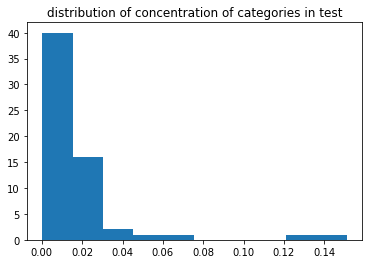

In [0]:
print('max concentration of items in 1 category', np.max(temp))
plt.hist(temp)
plt.title('distribution of concentration of categories in test')

So most categories are rare except to few to gather 15% of items; 

Then there is no over concentration of categories in test.

max concentration of items in 1 category 0.1455754664696102


Text(0.5, 1.0, 'distribution of concentration of categories in train')

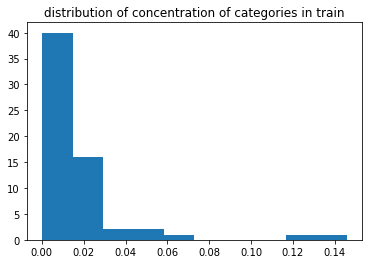

In [0]:
df["item_category_id"]=df["item_id"].map(pd.Series(items["item_category_id"].values,index=items["item_id"].values))
temp_train=[]
temp_df=df[df["date_block_num"]==33]
for i in temp_df["item_category_id"].unique():
    temp_train+=[len(temp_df[temp_df["item_category_id"]==i]['item_id'].unique())/len(temp_df['item_id'].unique())]
print('max concentration of items in 1 category', np.max(temp_train))
plt.hist(temp_train)
plt.title('distribution of concentration of categories in train')
#so most categories are rare except to few to gather 15% of items

The same is about train - all categories are spread out; 

<function matplotlib.pyplot.show>

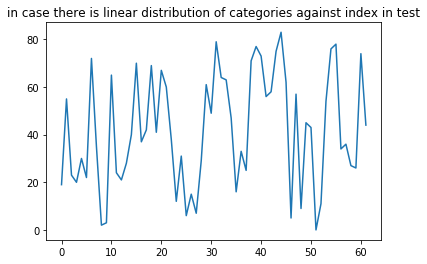

In [0]:
#finally any pattern in categories
plt.plot(sales_test[sales_test["shop_id"]==5]["item_category_id"].unique())
plt.title("in case there is linear distribution of categories against index in test")
plt.show

Summary:

from name of categories new feature major category can be extracted along with 4 dummies; 

categories that are absent in test are to be deleted as they are not very useful for the rest of data.